In [3]:
import pandas as pd

df = pd.read_json("guardian_world_structured_data/data_00001.jsonl", lines=True)
# print(df.head())
print(df.sample(5, random_state=42))

                                    id  \
1565  58ab4d574fde3481c099514c5e265917   
1419  51042e73115b539469e0a38efe0cb2c0   
4002  e2cc9361e377e9bbc2ded66f6597c32a   
1074  3e7d6c9ec60382b8ccfae76595b249ea   
3235  b66a343dced1df0ce021ae7efe156995   

                                                  title  \
1565                                Class-bound America   
1419                The religious warrior of Abu Ghraib   
4002                                  Scars and stripes   
1074                                      A world apart   
3235  Milan's opera world divided as British conduct...   

                  publish_time             author  \
1565  1999-12-01T20:02:11-0500    Godfrey Hodgson   
1419  2004-05-19T21:45:46-0400  Sidney Blumenthal   
4002  1998-11-01T20:49:57-0500               None   
1074  2001-09-23T21:30:36-0400  Madeleine Bunting   
3235  2005-12-08T08:00:32-0500    Barbara McMahon   

                                                   text  
1565  American 

📅 Time Range:
  Earliest publish time: 1939-09-04 06:41:57-04:00
  Latest publish time:   2008-09-27 19:01:00-04:00
  Time span:             25226 days 12:19:03
After conversion: datetime64[ns, UTC]
0   2001-07-26 01:14:51+00:00
1                         NaT
2   2003-09-20 01:43:15+00:00
3                         NaT
4                         NaT
Name: publish_time, dtype: datetime64[ns, UTC]

🕒 Articles per Year:
year
1939.0      2
1940.0      2
1941.0      1
1943.0      2
1944.0      2
1945.0      4
1953.0      1
1954.0      1
1958.0      1
1960.0      1
1962.0      1
1963.0      1
1964.0      1
1967.0      1
1968.0      1
1969.0      1
1973.0      1
1976.0      1
1981.0      1
1986.0      1
1988.0      2
1989.0      3
1990.0      1
1991.0      1
1992.0      4
1993.0      2
1994.0      3
1995.0      2
1996.0      1
1997.0      5
1998.0     12
1999.0    112
2000.0    261
2001.0    490
2002.0    385
2003.0    517
2004.0    536
2005.0    167
2008.0      1
Name: count, dtype: int64


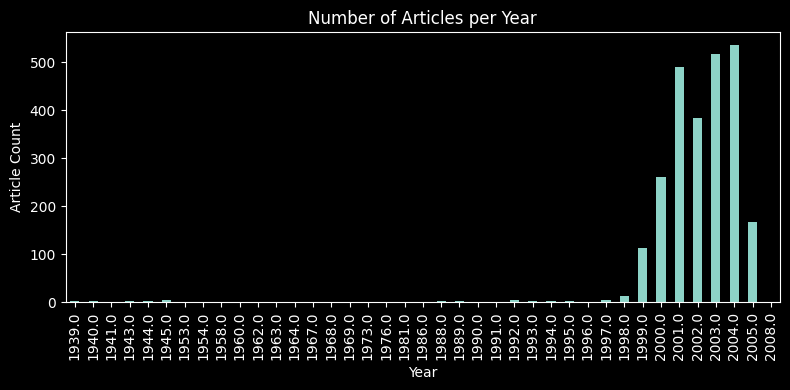


🧑‍💼 Author Statistics:
  Unique authors: 471

Top 10 Authors:
author
Unknown               1333
Julian Borger          162
Martin Kettle          141
Duncan Campbell         96
Chris McGreal           81
Suzanne Goldenberg      70
Jon Henley              68
Luke Harding            67
Brian Whitaker          67
Rory McCarthy           62
Name: count, dtype: int64


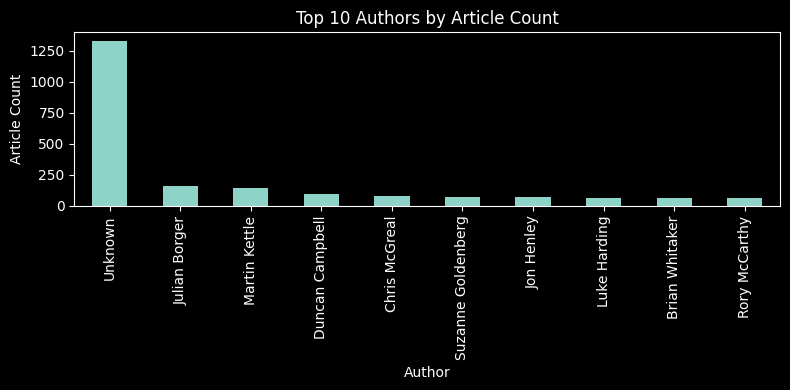


📏 Text Length Statistics:
count     4517.000000
mean      4571.968120
std       3473.063857
min         25.000000
25%       2618.000000
50%       3870.000000
75%       5299.000000
90%       7653.800000
95%       9887.400000
99%      20830.360000
max      36385.000000
Name: text_len, dtype: float64


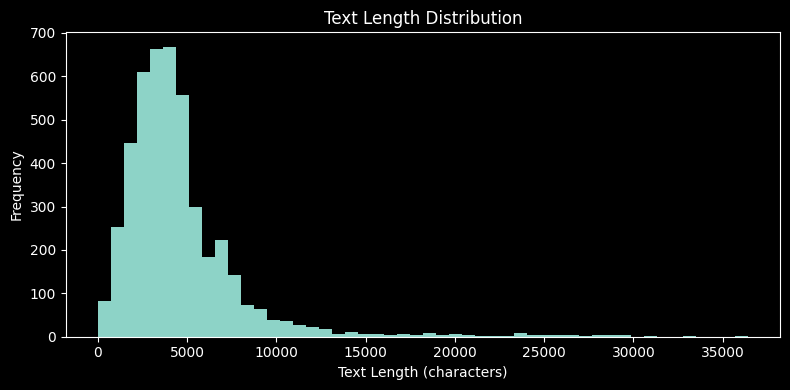


📰 Title Length Statistics:
count    4517.000000
mean       35.960815
std        14.219244
min         5.000000
25%        26.000000
50%        35.000000
75%        44.000000
max       200.000000
Name: title_len, dtype: float64


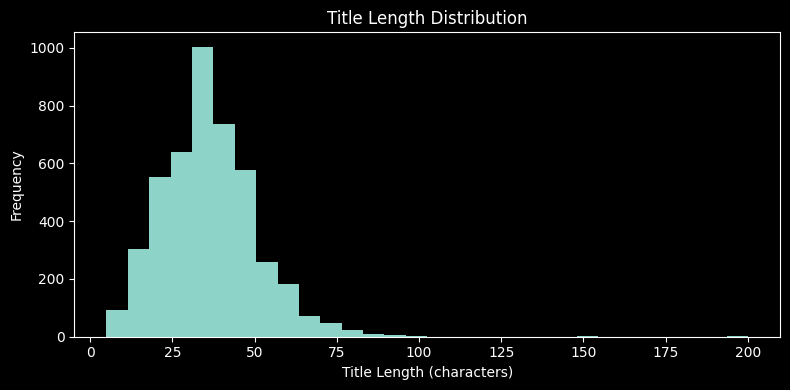

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert publish_time to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# ============ 1. Time Features ============
print("📅 Time Range:")
print(f"  Earliest publish time: {df['publish_time'].min()}")
print(f"  Latest publish time:   {df['publish_time'].max()}")
print(f"  Time span:             {df['publish_time'].max() - df['publish_time'].min()}")

# Yearly distribution
# 强制去掉多余空格并转换
df['publish_time'] = (
    df['publish_time']
    .astype(str)
    .str.strip()
    .apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))
)
# 检查转换结果
print("After conversion:", df['publish_time'].dtype)
print(df['publish_time'].head())
# 再创建 year 列
df['year'] = df['publish_time'].dt.year
# df['year'] = df['publish_time'].dt.year
year_counts = df['year'].value_counts().sort_index()
print("\n🕒 Articles per Year:")
print(year_counts)

plt.figure(figsize=(8,4))
year_counts.plot(kind='bar', title='Number of Articles per Year')
plt.xlabel('Year')
plt.ylabel('Article Count')
plt.tight_layout()
plt.show()


# ============ 2. Author Features ============
author_counts = df['author'].fillna('Unknown').value_counts()
print("\n🧑‍💼 Author Statistics:")
print(f"  Unique authors: {df['author'].nunique(dropna=True)}")
print("\nTop 10 Authors:")
print(author_counts.head(10))

plt.figure(figsize=(8,4))
author_counts.head(10).plot(kind='bar', title='Top 10 Authors by Article Count')
plt.xlabel('Author')
plt.ylabel('Article Count')
plt.tight_layout()
plt.show()


# ============ 3. Text Length Distribution ============
df['text_len'] = df['text'].str.len()
print("\n📏 Text Length Statistics:")
print(df['text_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

plt.figure(figsize=(8,4))
df['text_len'].plot(kind='hist', bins=50, title='Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# ============ 4. Title Length Distribution ============
df['title_len'] = df['title'].str.len()
print("\n📰 Title Length Statistics:")
print(df['title_len'].describe())

plt.figure(figsize=(8,4))
df['title_len'].plot(kind='hist', bins=30, title='Title Length Distribution')
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()